In [1]:
from fed.utils.pipeline import PairedFeatureBank, MMVAETrainer
from experiments.mmvae.mnist.model import (
    get_mnist_audio_encoder,
    get_mnist_image_encoder,
    _make_mlp
)
from experiments.mmvae.mnist.dataset import mmMNIST
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from reconstruct.mmvae import DecoupledMMVAE


from experiments.ssl.dataset import get_mnist_transform

import torchvision.transforms as T




device = 'cuda'
public_dataset_path = '/root/autodl-tmp/csv/mmMNIST_server.csv'
# public_dataset_path =  '/root/fedRec/clients/train/9.csv'

_, image_transform = get_mnist_transform()
image_transform = T.Compose(image_transform)
public_dataset = mmMNIST(public_dataset_path, with_label=True, image_transform=image_transform)

# CKP_PATH = '/root/fedRec/ckp/components/77/informed_gen_0.6_alpha_0.1.pt'
CKP_PATH = '/root/fedRec/ckp/components/77/ours.pt'

ckp = torch.load(CKP_PATH)

import torch.nn as nn
def get_proj_head(inplanes, hidden_dim, outplanes):
    return nn.Sequential(
        nn.Linear(inplanes, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, outplanes)
    )

from model.simclr import StandardPipeline

def get_extractor(mod):
    if mod == 'audio':
        backbone = get_mnist_audio_encoder()
    elif mod == 'image':
        backbone = get_mnist_image_encoder()
    return backbone

def make_mlp(inplanes, hidden_dim, out_dim, use_bn=False):
    if use_bn:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    else:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

audio_backbone = get_extractor('audio').to(device)
audio_backbone.load_state_dict(ckp['audio'])
audio_backbone.eval()

audio_proj_head = get_proj_head(64, 256, 128).to(device)
audio_proj_head.load_state_dict(ckp['audio_proj_head'])

image_backbone = get_extractor('image').to(device)
image_backbone.load_state_dict(ckp['image'])
image_backbone.eval()

image_proj_head = get_proj_head(64, 256, 128).to(device)
image_proj_head.load_state_dict(ckp['image_proj_head'])


def get_rec_network(embed_dim=64, hidden_dim=128):
    return make_mlp(embed_dim, hidden_dim, embed_dim, use_bn=False)


def get_mmvae(embed_dim=64, hidden_dim=128, bottleneck_dim=32):
    criterion = nn.MSELoss()
    mmvae_config = {
        'encoders' : nn.ModuleDict({
            '0' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=False),
            '1' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=False)
        }).to(device),
        'decoders' : nn.ModuleDict({
            '0' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=False),
            '1' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=False)
        }).to(device),
        'latent_dim' : bottleneck_dim,
        'score_fns' : {'0' : criterion, '1' : criterion}
    }
    mmvae = DecoupledMMVAE(**mmvae_config)
    return mmvae


KeyError: 'audio_proj_head'

In [2]:
from fed.utils.pipeline import PairedFeatureBank, MMVAETrainer
from experiments.mmvae.mnist.model import (
    get_mnist_audio_encoder,
    get_mnist_image_encoder,
    _make_mlp
)
from experiments.mmvae.mnist.dataset import mmMNIST
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from reconstruct.mmvae import DecoupledMMVAE


from experiments.ssl.dataset import get_mnist_transform

import torchvision.transforms as T




device = 'cuda'
public_dataset_path = '/root/autodl-tmp/csv/mmMNIST_server.csv'
# public_dataset_path =  '/root/fedRec/clients/train/9.csv'

_, image_transform = get_mnist_transform()
image_transform = T.Compose(image_transform)
public_dataset = mmMNIST(public_dataset_path, with_label=True, image_transform=image_transform)

CKP_PATH = '/root/fedRec/ckp/components/77/ours.pt'
ckp = torch.load(CKP_PATH)

import torch.nn as nn
def get_proj_head(inplanes, hidden_dim, outplanes):
    return nn.Sequential(
        nn.Linear(inplanes, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, outplanes)
    )

from model.simclr import StandardPipeline

def get_extractor(mod):
    if mod == 'audio':
        backbone = get_mnist_audio_encoder()
    elif mod == 'image':
        backbone = get_mnist_image_encoder()
    return backbone

def make_mlp(inplanes, hidden_dim, out_dim, use_bn=False):
    if use_bn:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    else:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

audio_backbone = get_extractor('audio').to(device)
audio_backbone.load_state_dict(ckp['audio'])
audio_backbone.eval()

# audio_proj_head = get_proj_head(64, 256, 128).to(device)
# audio_proj_head.load_state_dict(ckp['audio_proj_head'])

image_backbone = get_extractor('image').to(device)
image_backbone.load_state_dict(ckp['image'])
image_backbone.eval()

# image_proj_head = get_proj_head(64, 256, 128).to(device)
# image_proj_head.load_state_dict(ckp['image_proj_head'])


def get_rec_network(embed_dim=64, hidden_dim=128):
    return make_mlp(embed_dim, hidden_dim, embed_dim, use_bn=False)


def get_mmvae(embed_dim=64, hidden_dim=128, bottleneck_dim=32):
    criterion = nn.MSELoss()
    mmvae_config = {
        'encoders' : nn.ModuleDict({
            '0' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=False),
            '1' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=False)
        }).to(device),
        'decoders' : nn.ModuleDict({
            '0' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=False),
            '1' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=False)
        }).to(device),
        'latent_dim' : bottleneck_dim,
        'score_fns' : {'0' : criterion, '1' : criterion}
    }
    mmvae = DecoupledMMVAE(**mmvae_config)
    return mmvae


In [ ]:
class VAEAutoEncoder(nn.Module):
    def __init__(self,
                 encoder, decoder,
                 latent_dim):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder
        self.latent_dim = latent_dim
    def forward(self, x):
        z = self.encoder(x)
        mu, _ = torch.split(z, self.latent_dim, dim=-1)
        x_hat = self.decoder(mu)
        return x_hat

In [3]:
from torch.utils.data import Dataset
class ThinDatasetWrapper(Dataset):
    def __init__(self,
                 base_dataset,
                 out_index):
        super().__init__()
        self.base_dataset = base_dataset
        self.out_index = out_index
    def __len__(self):
        return len(self.base_dataset)
    def __getitem__(self, idx):
        base_out = self.base_dataset[idx]
        return [base_out[i] for i in self.out_index]

wrapped_dataset = ThinDatasetWrapper(
                    base_dataset=public_dataset,
                    out_index=[0,1]
                )

In [4]:
from reconstruct.mmvae.mmvae import _mod_ae

whole_audio = audio_backbone.to(device)
whole_image = image_backbone.to(device)

# toggle model state --> set it to eval mode
whole_audio.eval()
whole_image.eval()

# let's see can mmvae trained on this dataset

embed_dataset = PairedFeatureBank(
        wrapped_dataset,
        (whole_audio, whole_image, ),
        device,
        dataloader_config={'batch_size':32, 'shuffle':False},
)


In [5]:
import numpy as np
def _to_numpy(t):
    return t.detach().contiguous().cpu().numpy()
np_audio_dataset = []
np_image_dataset = []
for idx in range(len(embed_dataset)):
    np_audio_dataset.append(
       _to_numpy(embed_dataset[idx][0])
    )
    np_image_dataset.append(
        _to_numpy(embed_dataset[idx][1])
    )
np_audio_dataset = np.array(np_audio_dataset)
np_image_dataset = np.array(np_image_dataset)
np_image_dataset.shape

# np.save('audio_features.npy', np_audio_dataset)
# np.save('image_feature.npy', np_image_dataset)

(8000, 64)

In [6]:
import numpy as np
embed_label = []
for i in range(len(public_dataset)):
    embed_label.append(int(public_dataset[i][-1]))
embed_label = np.array(embed_label)
np.unique(embed_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

(8000, 64)


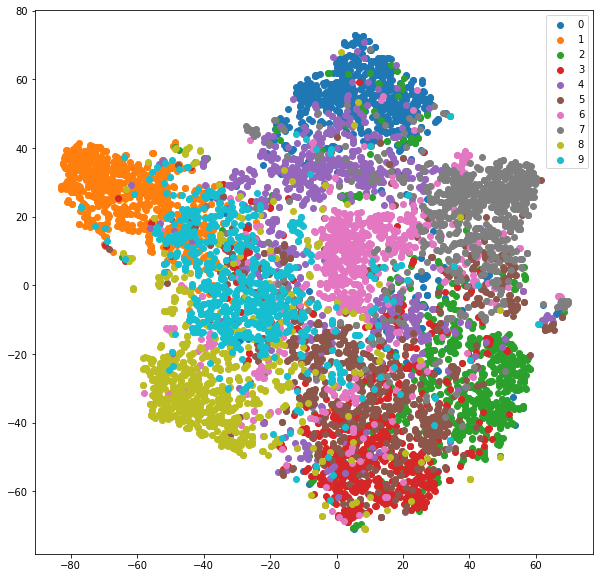

In [7]:
from sklearn.manifold import TSNE

feature_bank = np_audio_dataset
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

(8000, 64)


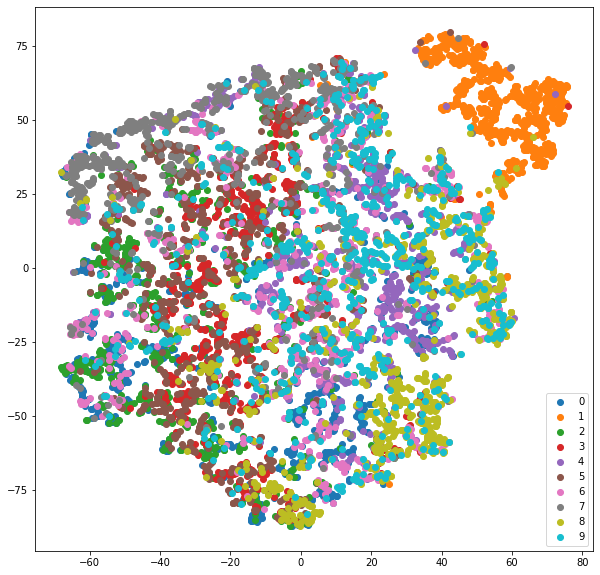

In [8]:
from sklearn.manifold import TSNE

feature_bank = np_image_dataset
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

In [34]:
from fed.facility import MMVAERecNetTrainer, MLPRecNetTrainer
mmvae_executor = MMVAERecNetTrainer(
    embed_dim=64, hidden_dim=32, bottleneck_dim=2,
    extractors=(audio_backbone, image_backbone, ),
    raw_dataset=wrapped_dataset,
    alpha=0.1,
)

In [35]:
mmvae_executor.run(5, verbose=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [15]:
mlp_executor = MLPRecNetTrainer(
    embed_dim=64, hidden_dim=32,
    extractors=(audio_backbone, image_backbone, ),
    raw_dataset=wrapped_dataset
)

In [16]:
mlp_executor.run(epoch=5, verbose=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [21]:
mlp_recnet_state_dict = mlp_executor.export_model()
embed_dim = 64
hidden_dim = 32
from experiments.mmvae.mnist.model import _make_mlp
mlp_image2audio = _make_mlp(embed_dim, hidden_dim, embed_dim).to(device)
mlp_audio2image = _make_mlp(embed_dim, hidden_dim, embed_dim).to(device)

mlp_audio2image.load_state_dict(mlp_recnet_state_dict['0_to_1'])
mlp_image2audio.load_state_dict(mlp_recnet_state_dict['1_to_0'])

<All keys matched successfully>

In [36]:
mmvae_state_dict = mmvae_executor.export_model()['mmvae']

mmvae = get_mmvae(64, 32, 2).to(device)
mmvae.load_state_dict(mmvae_state_dict)
# whole_audio = nn.Sequential(
#     audio_backbone,
#     mmvae.encoders['0'],
# ).to(device)

# whole_image = nn.Sequential(
#     image_backbone,
#     mmvae.encoders['1']
# ).to(device)

# mmvae_latent = PairedFeatureBank(
#         wrapped_dataset,
#         (whole_audio, whole_image, ),
#         device,
#         dataloader_config={'batch_size':32, 'shuffle':False},
# )


<All keys matched successfully>

In [29]:
from torch.utils.data import DataLoader
import numpy as np

def _to_numpy(t):
    return t.detach().contiguous().cpu().numpy()
image2audio = VAEAutoEncoder(mmvae.encoders['1'], mmvae.decoders['0'], 2)
audio2image = VAEAutoEncoder(mmvae.encoders['0'], mmvae.decoders['1'], 2)
dummy_dl = DataLoader(embed_dataset, batch_size=32, shuffle=False)

recon_audio = []
recon_image = []
for x in dummy_dl:
    audio_embed, image_embed = x
    with torch.no_grad():
        audio_cond_image = image2audio(image_embed)
        image_cond_audio = audio2image(audio_embed)
        recon_audio.append(_to_numpy(audio_cond_image))
        recon_image.append(_to_numpy(image_cond_audio))

recon_audio = np.concatenate(recon_audio, axis=0)
recon_image = np.concatenate(recon_image, axis=0)


(8000, 64)


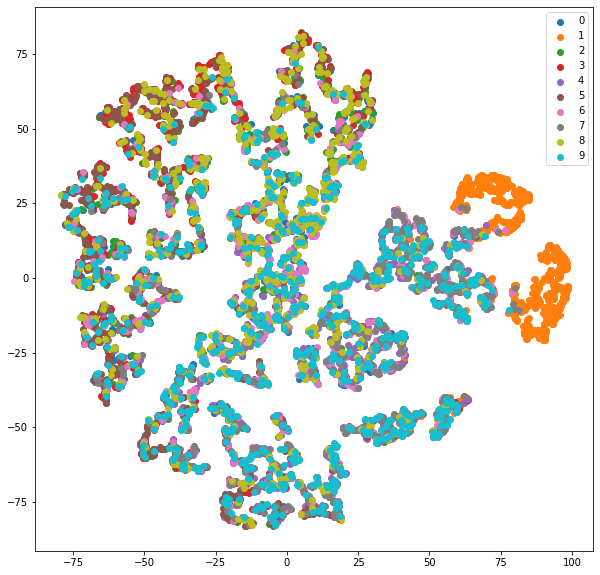

In [18]:
from sklearn.manifold import TSNE

feature_bank = recon_audio
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)[0]
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

In [37]:
import numpy as np
def _to_numpy(t):
    return t.detach().contiguous().cpu().numpy()


dummy_dl = DataLoader(embed_dataset, batch_size=32, shuffle=False)

latent_audio_dataset = []
latent_image_dataset = []
for x in dummy_dl:
    audio_embed, image_embed = x
    audio_z = mmvae.encoders['0'](audio_embed.to(device))
    image_z = mmvae.encoders['1'](image_embed.to(device))
    latent_audio_dataset.append(
       _to_numpy(audio_z)
    )
    latent_image_dataset.append(
       _to_numpy(image_z)
    )
latent_audio_dataset = np.concatenate(latent_audio_dataset, axis=0)
latent_image_dataset = np.concatenate(latent_image_dataset, axis=0)
latent_image_dataset.shape

(8000, 4)

In [34]:
drawn_audio_embed = []
for _ in range(80):
    drawn_audio_embed.append(
        _to_numpy(mmvae.generate(num_sample=100)['0'])
    )
drawn_audio_embed = np.concatenate(drawn_audio_embed, axis=0)
drawn_audio_embed.shape

(8000, 64)

In [39]:
isotropic_gaussian = np.random.normal(0, 1, (2000, 2))
isotropic_gaussian

array([[ 1.30844097, -1.23744696],
       [-0.02393742, -1.55263802],
       [-0.63383394,  0.04507223],
       ...,
       [ 0.12732226,  0.13665105],
       [ 0.43780422, -0.43632378],
       [-0.09835846,  1.24317627]])

In [72]:
def get_var(logvar):
    return np.exp(logvar)
get_var(latent_audio_dataset[:20, 2:])

array([[0.0445611 , 0.02600603],
       [0.07870563, 0.05307837],
       [0.06498056, 0.04892527],
       [0.06000317, 0.0407753 ],
       [0.04854307, 0.03069259],
       [0.03939305, 0.02379111],
       [0.05589501, 0.03899565],
       [0.04425442, 0.0283671 ],
       [0.04834826, 0.03045172],
       [0.03837652, 0.01953885],
       [0.05311304, 0.0355444 ],
       [0.04335333, 0.02524027],
       [0.06769259, 0.04778102],
       [0.046593  , 0.03051313],
       [0.03805635, 0.02300955],
       [0.05306859, 0.0349343 ],
       [0.05280608, 0.03460805],
       [0.04678912, 0.02826357],
       [0.04022471, 0.02336166],
       [0.04392014, 0.02742353]], dtype=float32)

In [73]:
latent_audio_dataset[:, :2]

array([[ 0.22340716,  0.6587808 ],
       [-0.27470475, -0.04086598],
       [-0.5920891 , -0.16581434],
       ...,
       [ 0.36953098,  1.386914  ],
       [ 0.48374677,  1.2479601 ],
       [ 0.14133386,  0.76348853]], dtype=float32)

(8000, 2)


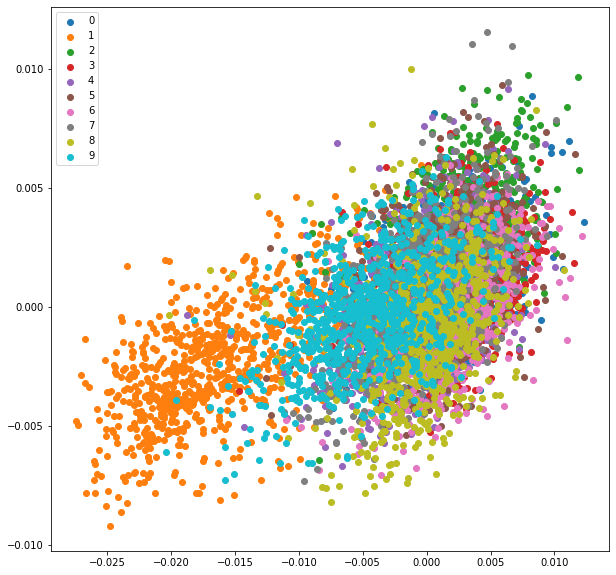

In [40]:
from sklearn.manifold import TSNE

feature_bank = latent_audio_dataset[:,:2]

isotropic_gaussian = np.random.normal(0, 1, (2000, 2))

def sample_parameterized_gaussian(mu, logvar):
    std = np.exp(logvar * 0.5)
    return np.random.normal(mu, std)

print(feature_bank.shape)
    
# embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)
embeds = feature_bank
ds = latent_audio_dataset[:,:2]

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)[0]
    # mu = latent_audio_dataset[idcs, :2]
    # logvar = latent_audio_dataset[idcs, 2:]
    # sampled_latent = sample_parameterized_gaussian(mu, logvar)    
    # plt.scatter(sampled_latent[:,0], sampled_latent[:, 1], label=idx)
    
    X = ds[idcs, 0]
    Y = ds[idcs, 1]
    plt.scatter(X, Y, label=idx)
# plt.scatter(isotropic_gaussian[:, 0], isotropic_gaussian[:, 1], label=10)
plt.legend()
plt.show()


In [93]:
def get_var(logvar):
    return np.exp(logvar)
print('mean:', latent_image_dataset[800:805, :2])
print('var:', get_var(latent_image_dataset[800:805, 2:]))

mean: [[ 0.00439042 -0.00693426]
 [ 0.0050391  -0.00581084]
 [ 0.00468334 -0.00565611]
 [ 0.00430516 -0.0060148 ]
 [ 0.00683916 -0.00732193]]
var: [[1.2018816 1.2003515]
 [1.2042161 1.1997585]
 [1.2038908 1.2004359]
 [1.2037586 1.2009963]
 [1.1998647 1.1989481]]


(8000, 4)


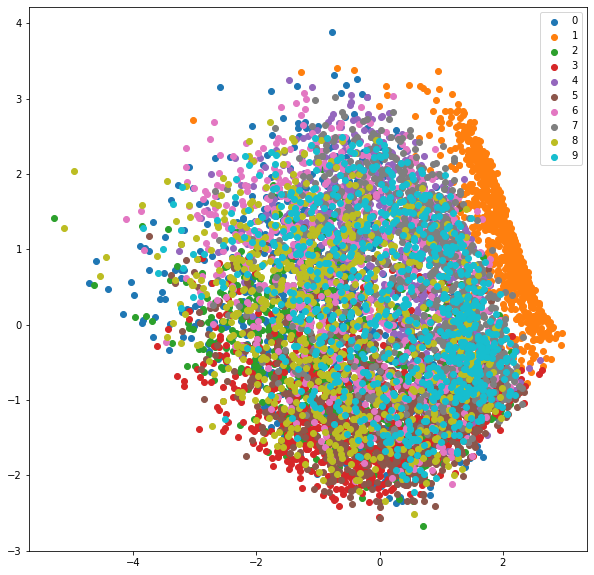

In [17]:
from sklearn.manifold import TSNE

feature_bank = latent_image_dataset
print(feature_bank.shape)
    
# embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)
embeds = feature_bank

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)[0]
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
# plt.scatter(isotropic_gaussian[:, 0], isotropic_gaussian[:, 1], label=10)
plt.legend()
plt.show()

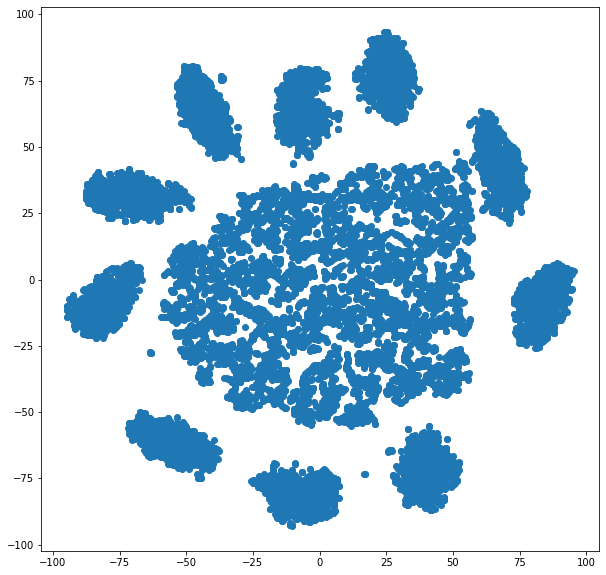

In [94]:
from sklearn.manifold import TSNE

feature_bank = np.concatenate(
    [drawn_audio_embed, np_audio_dataset], 
    axis=0
)
# print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
# for idx in range(20):
#     idcs = np.where(embed_label == idx)
#     X = embeds[idcs, 0]
#     Y = embeds[idcs, 1]
#     plt.scatter(X, Y, label=idx)
X = embeds[:,0]; Y = embeds[:,1]
plt.scatter(X, Y)
# plt.legend()
plt.show()

In [16]:
drawn_image_embed = []
for _ in range(80):
    drawn_image_embed.append(
        _to_numpy(mmvae.generate(num_sample=100)['1'])
    )
drawn_image_embed = np.concatenate(drawn_image_embed, axis=0)
drawn_image_embed.shape

(8000, 64)

(16000, 64)


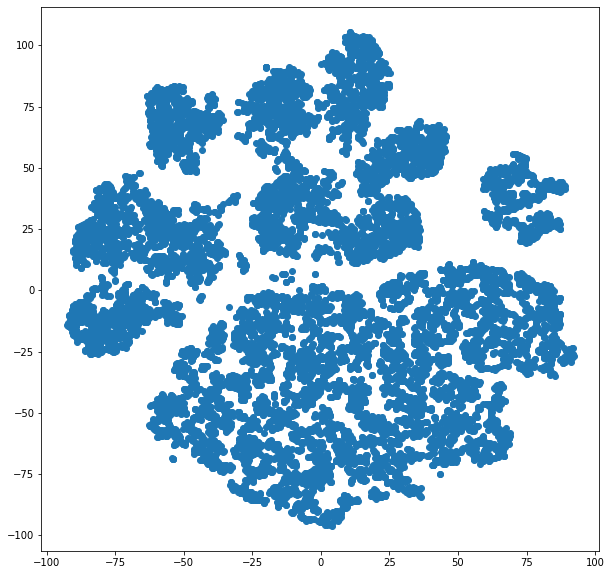

In [17]:
from sklearn.manifold import TSNE

feature_bank = np.concatenate(
    [drawn_image_embed, np_image_dataset], 
    axis=0
)
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
# for idx in range(20):
#     idcs = np.where(embed_label == idx)
#     X = embeds[idcs, 0]
#     Y = embeds[idcs, 1]
#     plt.scatter(X, Y, label=idx)
# plt.legend()
X = embeds[:,0]
Y = embeds[:,1]
plt.scatter(X, Y)
plt.show()